This notebook reads the daily pickle files created by '10_concat_csv_files_daily_pickles' and downsamples them using a 60-s mean average, and saves them as daily MiniSEED files

In [1]:
import header
paths = header.setup_environment()
import os
import pandas as pd
import datetime
import glob
COMBINED_DIR = os.path.join(paths['CORRECTED'], 'combined')
import obspy

In [2]:
def load_data_from_daily_pickle_files(start_dt, end_dt, instruments='Sensors', fs=100, resample=True, new_interval=None, max_samples=1000, \
                 average='median', to_stream=True, plot_data=True):
    start_date = start_dt.date()
    end_date = end_dt.date()    
    
    delta = datetime.timedelta(days=1)
    this_date = start_date
    combineddf = pd.DataFrame()
    while this_date <= end_date:
        #print(this_date.strftime("%Y-%m-%d"))
        combined_pklfile = f"{this_date}_{instruments}_{fs}Hz.pkl"
        combined_pklpath = os.path.join(COMBINED_DIR, combined_pklfile)
        print(combined_pklpath)
        if os.path.isfile(combined_pklpath):
            print('Loading ',combined_pklpath)
            if len(combineddf)>0:
                df = pd.read_pickle(combined_pklpath)
                combineddf = pd.concat([combineddf, df])
            else:
                combineddf = pd.read_pickle(combined_pklpath)
        else:
            print('file not found: ', combined_pklpath)
        this_date += delta

    if len(combineddf)==0:
        return None

    if not 'datetime'  in combineddf.columns:
        combineddf['datetime'] = [obspy.UTCDateTime(ts).datetime for ts in combineddf['TIMESTAMP']]

    # apply time subset
    mask = (combineddf['datetime'] >= start_dt) & (combineddf['datetime'] < end_dt)
    combineddf = combineddf.loc[mask]

    combineddf.set_index('datetime', inplace=True)
    combineddf.drop(columns=['TIMESTAMP', 'date', 'RECORD'], inplace=True)

    if resample or new_interval:
        if not new_interval:
            seconds = [1, 5, 10, 60, 300, 600, 900, 1800, 3600]
            seconds_index = 0
            estimated_delta = len(combineddf)/(max_samples * fs)
            
            while seconds[seconds_index] <= estimated_delta:
                seconds_index += 1
        
            new_interval = seconds[seconds_index] 
    
        print(f'resampling to {new_interval}-s sampling interval, taking median of each timewindow')
        if average=='median':
            combineddf = combineddf.resample(f"{new_interval}s").median()
        else:
            combineddf = combineddf.resample(f"{new_interval}s").mean()

        if len(combineddf)==0:
            return None
    
    #combineddf.reset_index(inplace=True)
    if to_stream:
        st = obspy.Stream()
        for col in combineddf.columns:
            tr = obspy.Trace(data=combineddf[col].to_numpy())
            tr.stats.starttime = obspy.UTCDateTime(combineddf.index[0])
            tr.stats.delta = obspy.UTCDateTime(combineddf.index[1]) - obspy.UTCDateTime(combineddf.index[0])
            tr.stats.network = col[0:2]
            if len(col)>7:
                tr.stats.station = col[2:7]
                if len(col)>9:
                    tr.stats.location = col[7:9]
                    tr.stats.channel = col[9:]
                else:
                    tr.stats.location = col[7:]
            else:
                tr.stats.station = col[2:]
            st.append(tr)
        if plot_data:
            st.plot(equal_scale=False);
        return st
    else:
        if plot_data:
            combineddf.plot(y=combineddf.columns)
        return combineddf

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-07-23_Sensors_1Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-07-23_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-07-24_Sensors_1Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-07-24_Sensors_1Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow


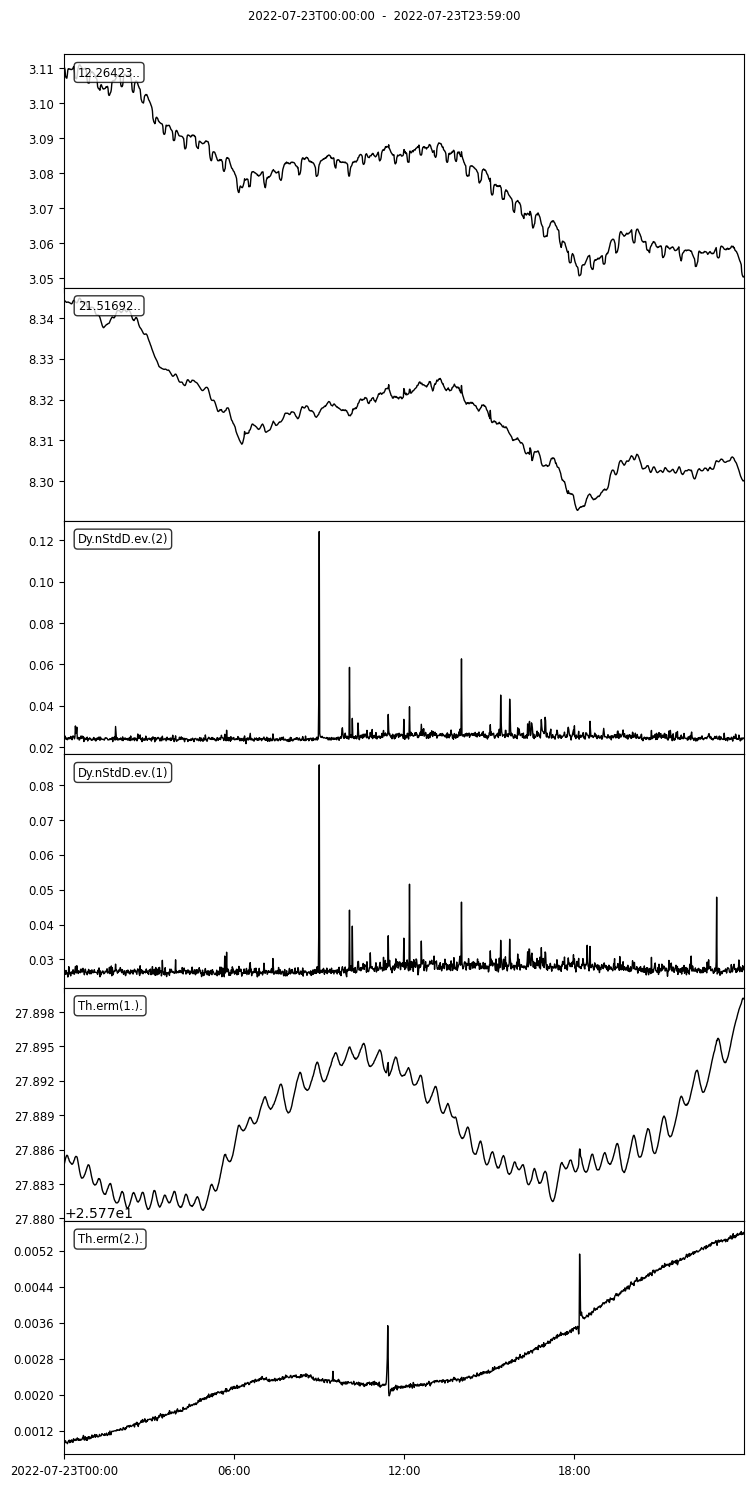

6 Trace(s) in Stream:
12.26423..      | 2022-07-23T00:00:00.000000Z - 2022-07-23T23:59:00.000000Z | 60.0 s, 1440 samples
21.51692..      | 2022-07-23T00:00:00.000000Z - 2022-07-23T23:59:00.000000Z | 60.0 s, 1440 samples
Th.erm(1.).     | 2022-07-23T00:00:00.000000Z - 2022-07-23T23:59:00.000000Z | 60.0 s, 1440 samples
Th.erm(2.).     | 2022-07-23T00:00:00.000000Z - 2022-07-23T23:59:00.000000Z | 60.0 s, 1440 samples
Dy.nStdD.ev.(1) | 2022-07-23T00:00:00.000000Z - 2022-07-23T23:59:00.000000Z | 60.0 s, 1440 samples
Dy.nStdD.ev.(2) | 2022-07-23T00:00:00.000000Z - 2022-07-23T23:59:00.000000Z | 60.0 s, 1440 samples


In [ ]:
start_dt = datetime.datetime(2022,7,23,0,0,0)
end_dt = datetime.datetime(2022,7,24,0,0,0)
st = load_data_from_daily_pickle_files(start_dt, end_dt, instruments='Sensors', fs=1, new_interval=60, average='mean')
#print(combineddf)
if st:
    print(st)

In [4]:
MSEED_DIR = os.path.join(paths['CORRECTED'], 'daily60s')
if not os.path.isdir(MSEED_DIR):
    os.makedirs(MSEED_DIR)
instrumentsList = ['Baro', 'Sensors', 'Sensors', 'Sensors']
fsList = [100, 1, 20, 100]
new_interval = 60
start_dt = datetime.datetime(2022,7,21,0,0,0)
end_dt = datetime.datetime(2022,12,3,0,0,0)
this_dt = start_dt
while this_dt < end_dt:
    that_dt = this_dt + datetime.timedelta(days=1)
    for instrumentIndex, instruments in enumerate(instrumentsList):
        fs = fsList[instrumentIndex]
        mseedfile = f"{this_dt.strftime('%Y%m%d')}_{instruments}_{fs}Hz_to_{new_interval}s.mseed"
        mseedpath = os.path.join(MSEED_DIR, mseedfile)
        if not os.path.isfile(mseedpath):
            st = load_data_from_daily_pickle_files(this_dt, that_dt, instruments=instruments, fs=fs, new_interval=60, average='mean', plot_data=False, to_stream=True)
            if st: # can be None
                print(mseedpath)
                try:
                    st.write(mseedpath, format='MSEED')
                except Exception as e:
                    print(e)
                    st.plot(equal_scale=False)
    this_dt = that_dt


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-04_Sensors_100Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-04_Sensors_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-05_Sensors_100Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-05_Sensors_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-05_Sensors_100Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-05_Sensors_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-06_Sensors_100Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-06_Sensors_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-06_Sensors_100Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-06_Sensors_100Hz.pkl
/home/thompsong

/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-27_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-27_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220826_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-26_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-26_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-27_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-27_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220826_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-27_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-27_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220827_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-27_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-27_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-27_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-27_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220827_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-27_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-27_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220827_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220828_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220828_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-28_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220828_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220829_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220829_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-29_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220829_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220830_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220830_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-30_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220830_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220831_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220831_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-08-31_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220831_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220901_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220901_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220901_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220902_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220902_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220902_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220903_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220903_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-03_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220903_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220904_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220904_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-04_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220904_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220905_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220905_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-05_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220905_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220906_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220906_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-06_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220906_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220907_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220907_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-07_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220907_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220908_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220908_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-08_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220908_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220909_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220909_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-09_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220909_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220910_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220910_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-10_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220910_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220911_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220911_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-11_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220911_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220912_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220912_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-12_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220912_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220913_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220913_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-13_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220913_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220914_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220914_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-14_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220914_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220915_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220915_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-15_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220915_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220916_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220916_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-16_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220916_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220917_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220917_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-17_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220917_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220918_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220918_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-18_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220918_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220919_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220919_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-19_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220919_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220920_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220920_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-20_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220920_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220921_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220921_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-21_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220921_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220922_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220922_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-22_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220922_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220923_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220923_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-23_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220923_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220924_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220924_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-24_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220924_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220925_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220925_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-25_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220925_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220926_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220926_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-26_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220926_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220927_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220927_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-27_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220927_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-29_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-29_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220928_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-29_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-29_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Sensors_20Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-29_Sensors

/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220928_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-28_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-29_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-29_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220928_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-29_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-29_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220929_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-29_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-29_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-29_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-29_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220929_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-29_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-29_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220929_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220930_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220930_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-30_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20220930_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221001_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221001_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-01_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221001_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221002_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221002_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-02_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221002_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221003_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221003_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-03_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221003_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221004_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221004_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-04_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221004_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221005_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221005_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-05_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221005_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221006_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221006_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-06_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221006_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221007_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221007_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-07_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221007_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221008_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221008_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-08_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221008_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221009_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221009_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-09_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221009_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221010_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221010_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-10_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221010_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221011_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221011_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-11_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221011_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221012_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221012_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-12_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221012_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221013_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221013_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-13_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221013_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221014_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221014_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-14_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221014_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221015_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221015_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-15_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221015_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-17_Baro_100Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-17_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221016_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-17_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-17_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-17_Sensors_20Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-17_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221016_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-16_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-17_Sensors_100Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-17_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221016_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-17_Baro_100Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-17_Baro_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-18_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-18_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-17_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-17_Sensors_1Hz.p

/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-18_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-18_Baro_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-19_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-19_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221018_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-18_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-18_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-19_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-19_Sensors_1Hz.pkl
/home/thomps

/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221018_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-19_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-19_Baro_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-20_Baro_100Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-20_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221019_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-19_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-19_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-20_Sensors_1Hz.pkl
file not fou

/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-20_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-20_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-21_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-21_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-20_Sensors_20Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-20_Sensors_20Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-21_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-21_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-20_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-22_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-22_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221021_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-21_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-21_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-22_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-22_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221021_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-22_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-22_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221022_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-22_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-22_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-22_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-22_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221022_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-22_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-22_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221022_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221023_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221023_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-23_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221023_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221024_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221024_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-24_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221024_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221025_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221025_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-25_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221025_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221026_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221026_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-26_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221026_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221027_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221027_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-27_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221027_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-29_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-29_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221028_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-29_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-29_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-29_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-29_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221028_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-28_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-29_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-29_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221028_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-29_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-29_Baro_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-30_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-30_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221029_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-29_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-29_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-30_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-30_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-29_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-29_Sensors_20Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-30_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-30_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/hom

/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221029_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-30_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-30_Baro_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-31_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-31_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221030_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-30_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-30_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-31_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-31_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-30_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-30_Sensors_20Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-31_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-31_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221030_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-30_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-30_Sensors_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-31_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-31_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221030_Sensors_100Hz_to_60s.mseed


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-31_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-31_Baro_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221031_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-31_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-31_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-31_Sensors_20H

/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221031_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-31_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-10-31_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221031_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221101_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221101_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-01_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221101_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221102_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221102_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-02_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221102_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221103_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221103_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-03_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221103_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221104_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221104_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-04_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221104_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221105_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221105_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-05_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221105_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221106_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221106_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-06_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221106_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221107_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221107_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-07_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221107_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221108_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221108_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-08_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221108_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221109_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221109_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-09_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221109_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221110_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221110_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-10_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221110_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221111_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221111_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-11_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221111_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Baro_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221112_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Sensors_20Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221112_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-12_Sensors_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221112_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-14_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-14_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221113_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-14_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-14_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Sensors_20Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-14_Sensors

/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221113_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-13_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-14_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-14_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221113_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-14_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-14_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221114_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-14_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-14_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-14_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-14_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221114_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-14_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-14_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221114_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221115_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221115_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-15_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221115_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221116_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221116_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-16_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221116_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221117_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221117_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-17_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221117_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221118_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221118_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-18_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221118_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221119_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221119_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-19_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221119_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-21_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-21_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221120_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-21_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-21_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Sensors_20Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-21_Sensors

/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221120_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-20_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-21_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-21_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221120_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-21_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-21_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-22_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-22_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221121_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-21_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-21_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-22_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-22_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-21_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-21_Sensors_20Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-22_Sensors

/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221121_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-21_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-21_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-22_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-22_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221121_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-22_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-22_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-23_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-23_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221122_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-22_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-22_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-23_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-23_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-22_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-22_Sensors_20Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-23_Sensors

/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221122_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-22_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-22_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-23_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-23_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221122_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-23_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-23_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221123_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-23_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-23_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-23_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-23_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221123_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-23_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-23_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221123_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221124_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221124_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-24_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221124_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221125_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221125_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-25_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221125_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221126_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221126_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-26_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221126_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221127_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221127_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-27_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221127_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221128_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221128_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-28_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221128_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221129_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221129_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-29_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221129_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221130_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221130_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-11-30_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221130_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-02_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-02_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221201_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-02_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-02_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Sensors_20Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-02_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-02_Sensors_20Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221201_Sensors_20Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-01_Sensors_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-02_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-02_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221201_Sensors_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-02_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-02_Baro_100Hz.pkl


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-03_Baro_100Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-03_Baro_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221202_Baro_100Hz_to_60s.mseed
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-02_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-02_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-03_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-03_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-02_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-02_Sensors_20Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-03

/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)


/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-03_Sensors_100Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-12-03_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/daily60s/20221202_Sensors_100Hz_to_60s.mseed


/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[0].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[1].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[2].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non contiguous data array in Stream[3].data. Trying to fix array.
  warnings.warn(msg)
/home/thompsong/miniconda3/envs/skience24_pyrocko/lib/python3.11/site-packages/obspy/io/mseed/core.py:695: UserWarning: Detected non con

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Baro_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Baro_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Baro_100Hz.pkl


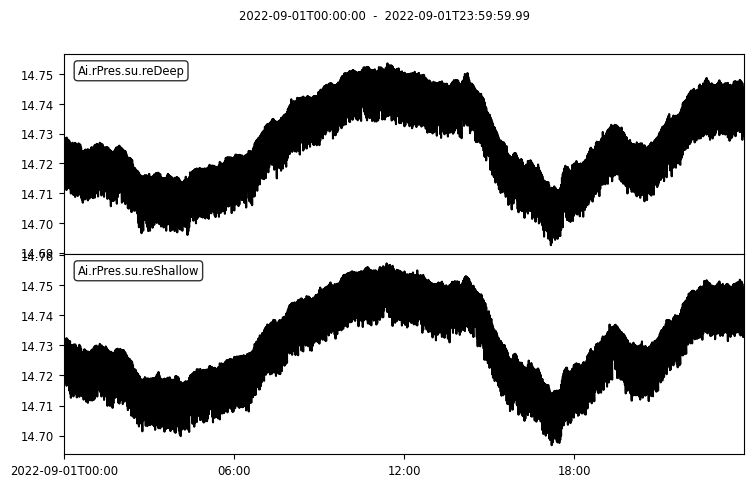

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_1Hz.pkl
file not found:  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_1Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_20Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_20Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_20Hz.pkl


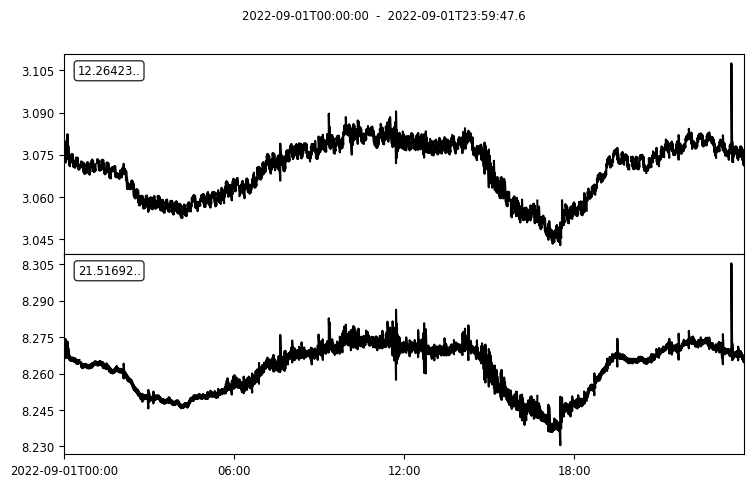

/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-01_Sensors_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-09-02_Sensors_100Hz.pkl


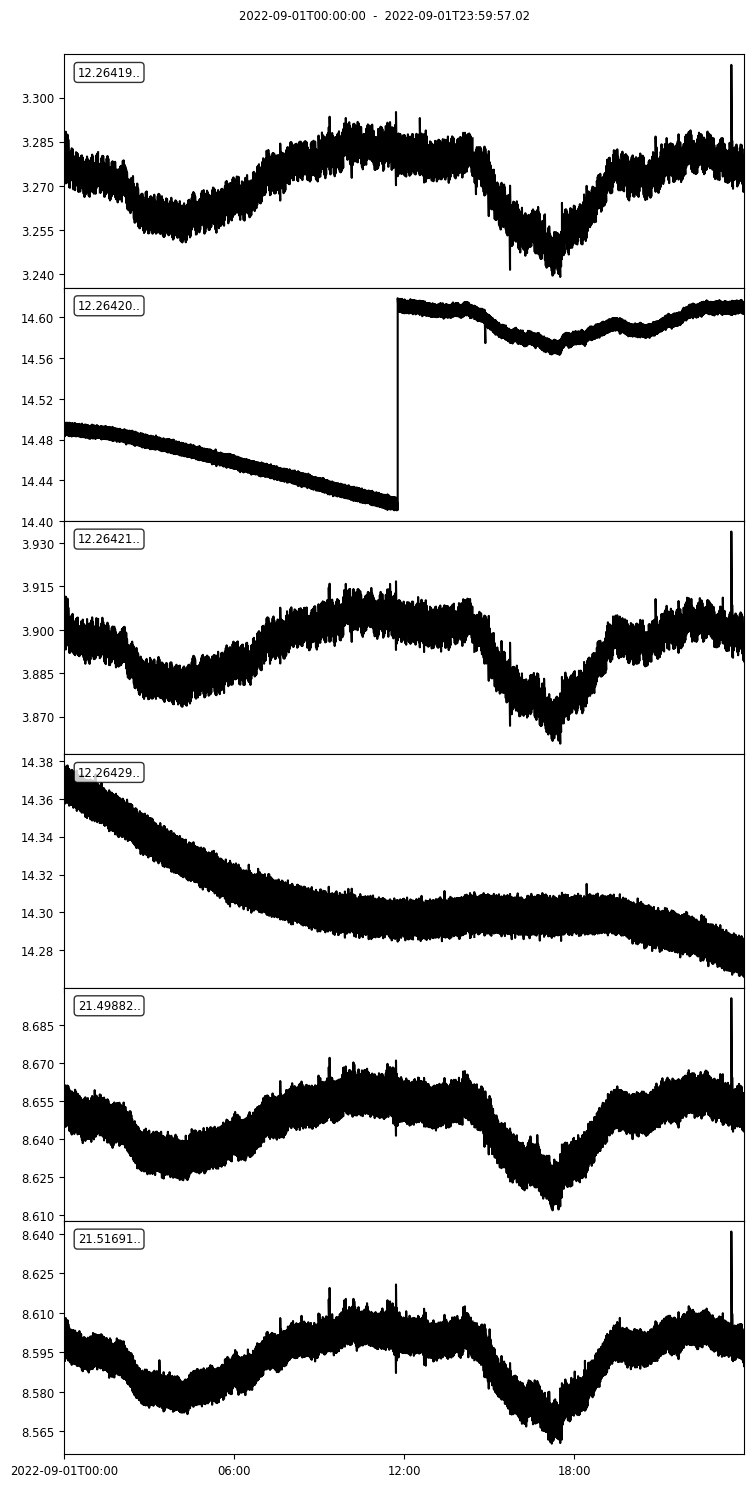

In [4]:
# plot a rocket launch
instrumentsList = ['Baro', 'Sensors', 'Sensors', 'Sensors']
fsList = [100, 1, 20, 100]
start_dt = datetime.datetime(2022,9,1,0,0,0)
end_dt = datetime.datetime(2022,9,2,0,0,0)
for instrumentIndex, instruments in enumerate(instrumentsList):
    fs = fsList[instrumentIndex]
    st = load_data_from_daily_pickle_files(start_dt, end_dt, instruments=instruments, fs=fs, plot_data=True, to_stream=True, resample=False)
    